# 6. 综合项目（房地产市场分析）

## 1. 准备工作（库导入）

In [10]:
# 1. 导入库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['SimHei'] #win
rcParams['font.sans-serif'] = ['STHeiti'] #mac

## 2.准备工作（数据导入）

In [11]:
# 2. 导入数据
df = pd.read_csv('data/house_sales.csv')

## 3. 准备工作（数据概览）

In [12]:
# 3. 数据概览
print('总记录数：', len(df))
print('字段数量：', len(df.columns))

总记录数： 106118
字段数量： 12


In [13]:
df.head(5)

,city,address,area,floor,name,price,province,rooms,toward,unit,year,origin_url
0,合肥,龙岗-临泉东路和王岗大道交叉口东南角,90㎡,中层（共18层）,圣地亚哥,128万,安徽,3室2厅,南北向,14222元/㎡,2013年建,https://hf.esf.fang.com/chushou/3_404230646.htm
1,合肥,龙岗-临泉东路和王岗大道交叉口东南角,90㎡,中层（共18层）,圣地亚哥,128万,安徽,3室2厅,南北向,14222元/㎡,2013年建,https://hf.esf.fang.com/chushou/3_404230646.htm
2,合肥,生态公园-淮海大道与大众路交口,95㎡,中层（共18层）,正荣·悦都荟,132万,安徽,3室2厅,南向,13895元/㎡,2019年建,https://hf.esf.fang.com/chushou/3_404304901.htm
3,合肥,生态公园-淮海大道与大众路交口,95㎡,中层（共18层）,正荣·悦都荟,132万,安徽,3室2厅,南向,13895元/㎡,2019年建,https://hf.esf.fang.com/chushou/3_404304901.htm
4,合肥,撮镇-文一名门金隅裕溪路与东风大道交口,37㎡,中层（共22层）,文一名门金隅,32万,安徽,2室1厅,南北向,8649元/㎡,2017年建,https://hf.esf.fang.com/chushou/3_404372096.htm


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106118 entries, 0 to 106117
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   city        106118 non-null  object
 1   address     104452 non-null  object
 2   area        105324 non-null  object
 3   floor       104024 non-null  object
 4   name        105564 non-null  object
 5   price       105564 non-null  object
 6   province    106118 non-null  object
 7   rooms       104036 non-null  object
 8   toward      105240 non-null  object
 9   unit        105564 non-null  object
 10  year        57736 non-null   object
 11  origin_url  105564 non-null  object
dtypes: object(12)
memory usage: 9.7+ MB


## 4. 准备工作（数据清洗）

In [15]:
# 4. 数据清洗
# 删除无用的数据列
df.drop(columns='origin_url',inplace=True)

In [16]:
# 检查是否有缺失值
df.isna().sum()
# 删除缺失值
df.dropna(inplace=True)

In [17]:
# 检查是否有重复值
df.duplicated().sum()
# 删除重复数据
df.drop_duplicates(inplace=True)
# print(len(df))
# 面积的数据类型转换
df['area'] = df['area'].str.replace('㎡','').astype(float)
# 售价的数据类型转换
df['price'] = df['price'].str.replace('万','').astype(float)
# 朝向的数据类型转换
df['toward'] = df['toward'].astype('category')
# 单价的数据类型转换
df['unit'] = df['unit'].str.replace('元/㎡','').astype(float)
# 建造年份的数据类型转换
df['year'] = df['year'].str.replace('年建','').astype(int)

In [18]:
# 异常值的处理
# 房屋面积的异常处理
df = df[ (df['area']<600) & (df['area']>20)]

In [19]:
# 房屋售价的异常处理  IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
low_price = Q1 - 1.5*IQR
high_price = Q3 + 1.5*IQR
df = df[ (df['price']<high_price) & (df['price']>low_price) ]

## 5. 新数据特征构造

In [20]:
# 5. 新数据特征构造
# 地区district
df['district'] = df['address'].str.split('-').str[0]
# 楼层的类型floor_type
df['floor_type'] = df['floor'].str.split('（').str[0].astype('category')
def fun1(str1):
    if pd.isna(str1):
        return '未知'
    elif '低' in str1:
        return '低楼层'
    elif '中' in str1:
        return '中楼层'
    elif '高' in str1:
        return '高楼层'
    else:
        return '未知'
df['floor_type2'] = df['floor'].apply(fun1).astype('category')
# 是否是直辖市zxs
df['zxs'] = df['city'].apply(lambda x: 1 if x in ['北京','上海','天津','重庆'] else 0)
# 卧室的数量bedrooms
df['bedrooms'] = df['rooms'].str.split('室').str[0].astype(int)
# 客厅的数量livingrooms
# df['rooms'].str.split('室').str[1].str.split('厅').str[0].astype(int)
df['livingrooms'] = df['rooms'].str.extract(r'(\d+)厅').astype('int')
# 楼龄building_age
df['building_age'] = 2025 - df['year']
# 价格的分段price_labels
df['price_labels'] = pd.cut(df['price'],bins=4,labels=['低价','中价','高价','豪华'])

## 6. 问题分析及可视化

### 1. 哪些变量最影响房价？面积、楼层、房间数哪个影响更大？

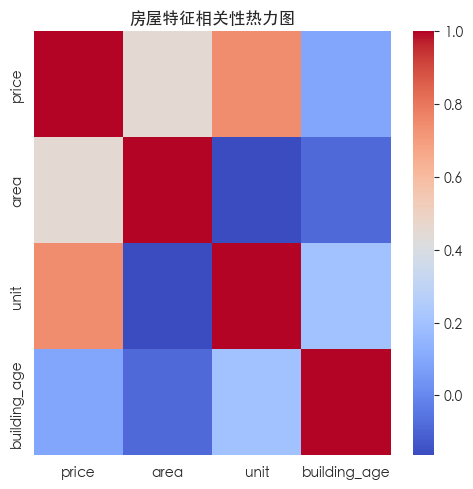

In [21]:
'''
问题编号: A1
问题: 哪些变量最影响房价？面积、楼层、房间数哪个影响更大？
分析主题: 特征相关性
分析目标: 了解房屋各特征对房价的线性影响
分组字段: 无
指标/方法: 皮尔逊相关系数
'''
# 选择数值型特征
a = df[['price','area','unit','building_age']].corr()#相关系数
# 对房价的影响最大的几个因素的排序
a['price'].sort_values(ascending=False)[1:]
# 相关性的热力图
plt.figure(figsize = (5,5))
sns.heatmap(a,cmap='coolwarm')
plt.title('房屋特征相关性热力图')
plt.tight_layout()
# df.head()

### 2.全国房价总体分布是怎样的？是否存在极端值？

<Axes: xlabel='price', ylabel='Count'>

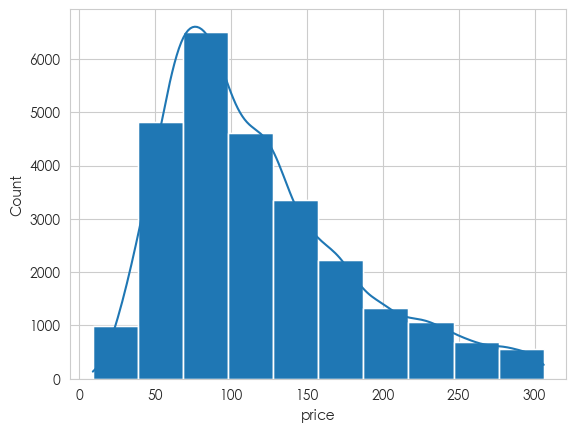

In [22]:
'''
问题编号: A2
问题: 全国房价总体分布是怎样的？是否存在极端值？
分析主题: 描述性统计
分析目标: 概览数值型字段的分布特征
分组字段: 无
指标/方法: 平均数/中位数/四分位数/标准差
'''
df.describe()
# 房价分布直方图
plt.subplot(111)
plt.hist(df['price'],bins=10)
df.head()
sns.histplot(data=df,x='price',bins=10,kde=True)

### 3.哪些城市房价最高？直辖市与非直辖市差异如何？


各城市房价统计:


price                        unit         
            mean  median count          mean   median
city                                                 
深圳    250.769231  266.00    13  47923.307692  42190.0
桐庐    190.124600  201.85    50  28016.580000  25556.5
淳安    206.106667  208.00    45  27942.377778  29563.0
上海    184.794444  207.00    54  27447.703704  27319.5
蓟州    190.321944  178.50    72  25995.027778  22035.5
杭州    191.910000  200.00    40  25972.125000  23239.5
厦门    201.264706  209.00    17  25074.705882  26018.0
福州    189.452174  191.00    46  24693.673913  22180.5
建德    171.941190  157.00    42  24198.714286  24398.0
苏州    210.793056  212.50    72  24088.111111  22797.5

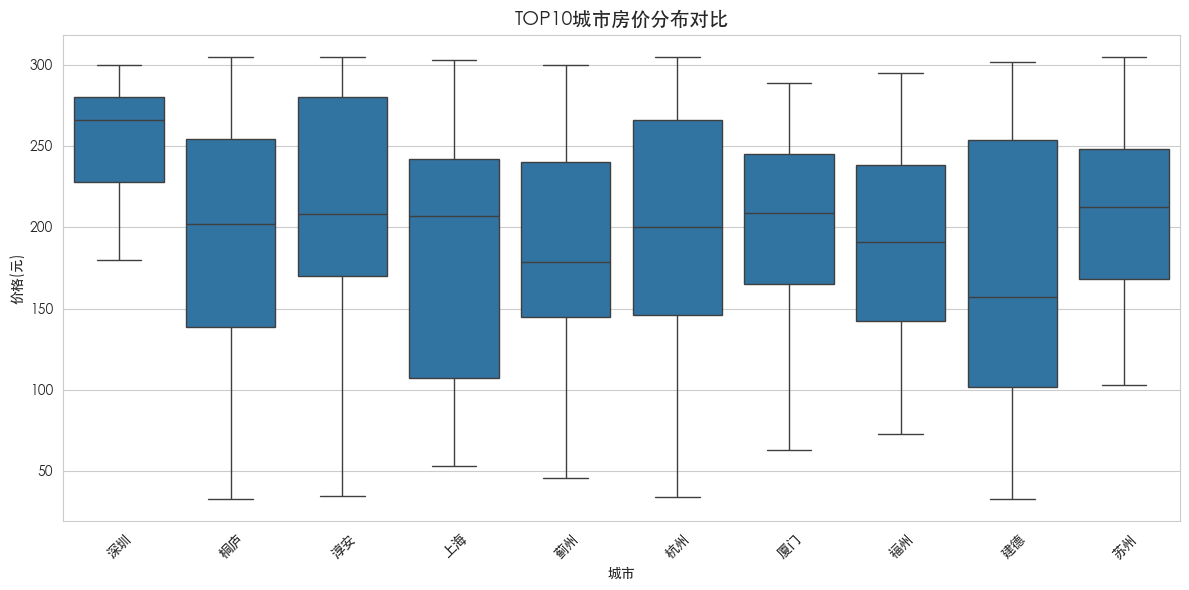

In [23]:
'''
问题编号: A3
问题: 哪些城市房价最高？直辖市与非直辖市差异如何？
分析主题: 城市对比
分析目标: 比较不同城市房价水平
分组字段: city
指标/方法: 均价/单价中位数/箱线图
'''
# 按城市统计
city_stats = df.groupby('city').agg({
    'price': ['mean', 'median', 'count'],
    'unit': ['mean', 'median']
})
print("\n各城市房价统计:")
display(city_stats.sort_values(('unit', 'mean'), ascending=False).head(10))

# 可视化前10城市
top_cities = city_stats.sort_values(('unit', 'mean'), ascending=False).head(10).index
df_top = df[df['city'].isin(top_cities)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='price', data=df_top, order=top_cities)
plt.title('TOP10城市房价分布对比', fontsize=14)
plt.xlabel('城市')
plt.ylabel('价格(元)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4. 高价房在面积、楼层等方面有什么特征？


=== A4 价格分层特征差异 ===

各价格层级特征对比:


/var/folders/5j/mbr6h6qj5m7f4_448mz7w6l80000gn/T/ipykernel_63139/2951655543.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_group = df.groupby('price_labels').agg({


area         building_age     unit       zxs
                    mean  median         mean   median      mean
price_labels                                                    
低价             87.268551   89.00    11.443039   7059.0  0.005560
中价            106.224389  102.00    11.796632  10909.0  0.007656
高价            120.495043  118.51    12.796065  15979.5  0.012716
豪华            135.724985  134.00    13.277942  19915.0  0.024246

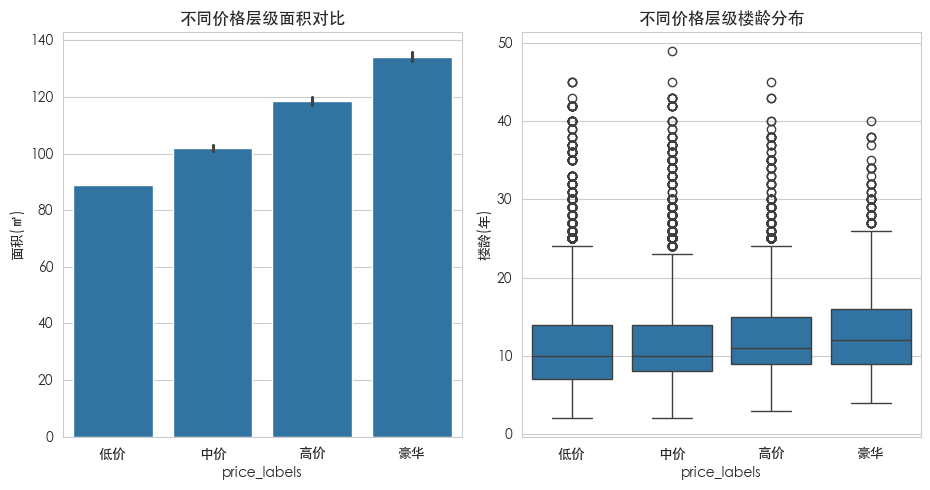

In [24]:
'''
问题编号: A4
问题: 高价房在面积、楼层等方面有什么特征？
分析主题: 价格分层
分析目标: 识别不同价位房屋特征差异
分组字段: 价格分段(低中高)
指标/方法: 列联表/卡方检验
'''
"""A4 价格分层特征差异分析"""
print("\n=== A4 价格分层特征差异 ===")

# 按价格分段分析特征
price_group = df.groupby('price_labels').agg({
    'area': ['mean', 'median'],
    'building_age': 'mean',
    'unit': 'median',
    'zxs': 'mean'  # 直辖市占比
})

print("\n各价格层级特征对比:")
display(price_group)

# 可视化
plt.figure(figsize=(14, 5))

plt.subplot(131)
sns.barplot(x='price_labels', y='area', data=df, estimator=np.median)
plt.title('不同价格层级面积对比')
plt.ylabel('面积(㎡)')

plt.subplot(132)
sns.boxplot(x='price_labels', y='building_age', data=df)
plt.title('不同价格层级楼龄分布')
plt.ylabel('楼龄(年)')


plt.tight_layout()
plt.show()

### 5.哪种户型最受欢迎？三室比两室贵多少？


=== A5 户型分析 ===

各户型市场表现:


price            unit     area    city
                  mean median   median   median nunique
room_count                                             
1.0          61.327938   50.0  10779.0   46.000     303
0.0          69.384615   55.0  10000.0   79.000       8
2.0         102.952484   93.8  11504.0   84.000     359
3.0         123.399640  108.0   9818.0  110.000     366
4.0         152.806253  139.8   9859.0  140.000     341
8.0         160.000000  126.5   5043.0  281.500       5
7.0         163.500000  145.5   5580.0  273.000       7
5.0         167.835338  157.0   8696.0  187.390     139
9.0         182.250000  171.5   5141.5  394.375       4
6.0         195.852703  188.0   8504.5  221.000      55

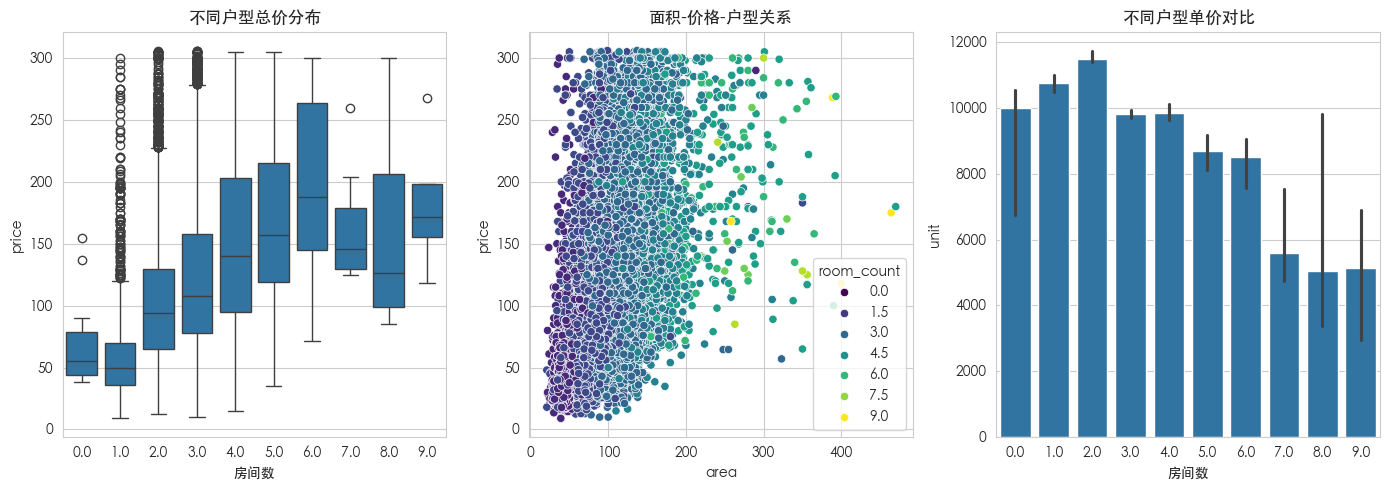

In [25]:
'''
问题编号: A5
问题: 哪种户型最受欢迎？三室比两室贵多少？
分析主题: 户型分析
分析目标: 分析不同户型的市场表现
分组字段: rooms
指标/方法: 占比/平均单价/溢价率
'''
"""A5 户型市场表现分析"""
print("\n=== A5 户型分析 ===")

# 提取房间数（示例："3室2厅" -> 3）
df['room_count'] = df['rooms'].str.extract('(\d+)室').astype(float)

# 按户型统计
room_stats = df.groupby('room_count').agg({
    'price': ['mean', 'median'],
    'unit': 'median',
    'area': 'median',
    'city': 'nunique'
}).sort_values(('price', 'mean'))

print("\n各户型市场表现:")
display(room_stats)

# 可视化
plt.figure(figsize=(14, 5))

plt.subplot(131)
sns.boxplot(x='room_count', y='price', data=df)
plt.title('不同户型总价分布')
plt.xlabel('房间数')

plt.subplot(132)
sns.scatterplot(x='area', y='price', hue='room_count', data=df, palette='viridis')
plt.title('面积-价格-户型关系')

plt.subplot(133)
sns.barplot(x='room_count', y='unit', data=df, estimator=np.median)
plt.title('不同户型单价对比')
plt.xlabel('房间数')

plt.tight_layout()
plt.show()

### 6.南北向是否真比单一朝向贵？贵多少？

/var/folders/5j/mbr6h6qj5m7f4_448mz7w6l80000gn/T/ipykernel_63139/397367962.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('toward').agg({


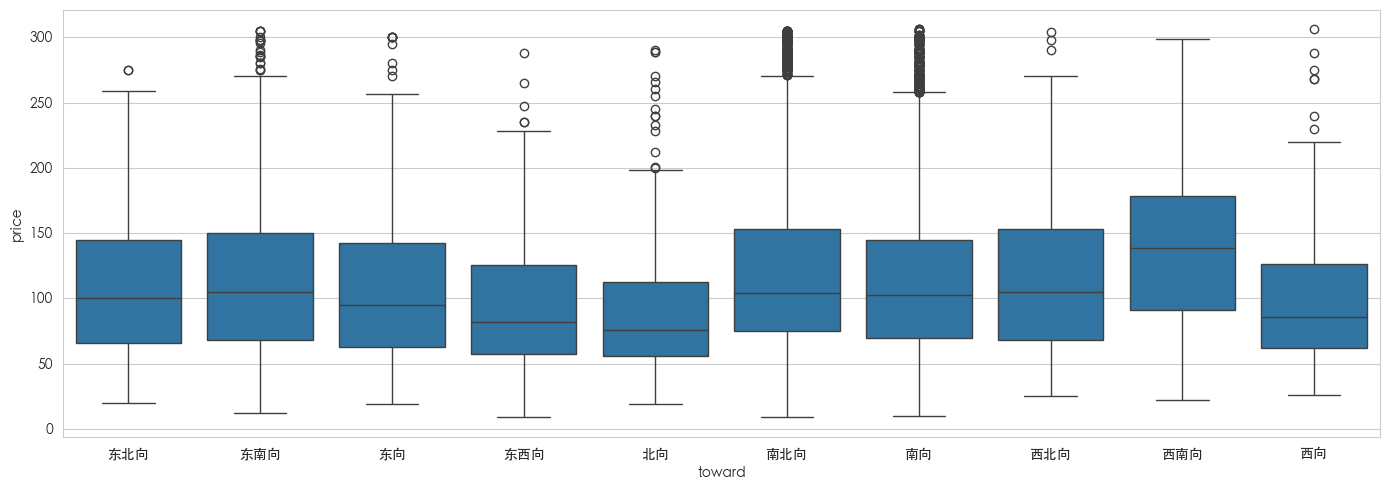

In [26]:
'''
问题编号: A6
问题: 南北向是否真比单一朝向贵？贵多少？
分析主题: 朝向溢价
分析目标: 评估不同朝向的价格差异
分组字段: toward
指标/方法: 方差分析/多重比较
'''
df['toward'].value_counts()
df.groupby('toward').agg({
    'price':['mean','median'],
    'unit':'median',
    'building_age':'mean',
})
# 数据可视化
plt.figure(figsize=(14, 5))
sns.boxplot(x='toward', y='price', data=df)
plt.tight_layout()